In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import time
import sys
import mat73
import os
import re
from scipy import stats
import shutil
from datetime import datetime
import seaborn as sns

# FOOOF objects and functions
from fooof import FOOOFGroup, FOOOF
from fooof.bands import Bands
from fooof.plts.spectra import plot_spectrum
from fooof.plts.annotate import plot_annotated_model
from fooof.analysis import get_band_peak_fm, get_band_peak_fg
from fooof.utils.reports import methods_report_info

# RBL functions
from  import_NK_spectra import import_NK_spectra
from  import_FT_RCS_spectra import import_FT_RCS_spectra
from  RBL_fooof_fxns import  setup_fooof_dirs, plt_save_fooof_analysis, plt_save_avg_peaks #plt_save_aperiodic_overtime, plt_save_periodic

In [5]:
### RBL inputs into general FOOOF approach below:
fooof_param = pd.DataFrame

fooof_param.freq_range = [2, 40] 

fooof_param.err_thresh = 0.15

## FOOOF alogirthim parameters (directly feed into FOOOF object)
fooof_param.peak_width_limits   = [2.0, 6.0]      # narrowest to widest possible peak width
fooof_param.max_n_peaks         = 3               # max number of peaks to fit
fooof_param.min_peak_height     = 0.3             # min power (db) ABOVE flattened spectrum to be considered a peak
fooof_param.peak_threshold      = 2               # min std(s) above flattened spectrum to be considered a peak
fooof_param.aperiodic_mode      ='fixed'          # 'fixed' = 1/(f^x), but 'knee' = 1/(k + f^x)--the latter allows an inflection point in the aperiodic fit

## FOOOF inpatient (NK, stage 0) spectra
* set pts and directories of where spectra exported are and where outputs should be saved

In [6]:
pts = ['RCS02', 'RCS04', 'RCS05', 'RCS06', 'RCS07']

dirs = {'raw':       '/Volumes/DBS Pain 3/nk_device_data/processed/fooof_specs (30s_prior_to_survey, updated channels)/',
        'proc':      '/Users/Leriche/pia_server/datastore_spirit/human/nk_device_data/ephy_analysis/spectra/',
        'raw_sub':   '',
        'proc_sub':  'fooofed',
        'rcs_raw':   '/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/'
       }

* main loop of FOOOFing and exporting inpatient spectra of interest* set pts and directories of where spectra exported are and where outputs should be saved* set pts and directories of where spectra exported are and where outputs should be saved

RCS02
['RVPN 3-1']
(106, 1, 298)
(298,)


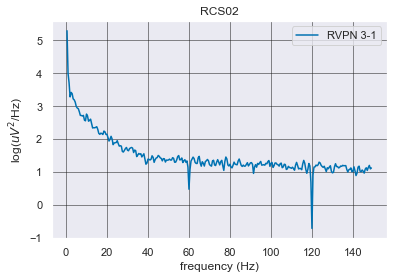

Running FOOOFGroup across 88 power spectra.
See:   /Users/Leriche/pia_server/datastore_spirit/human/nk_device_data/ephy_analysis/spectra//RCS02/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
RCS04
['LACC 5-3', 'RACC 5-3', 'LACC 5-4', 'RACC 5-4']
(142, 4, 298)
(298,)


<Figure size 432x288 with 0 Axes>

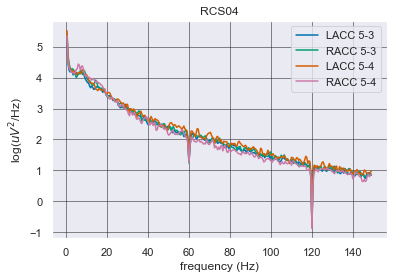

Running FOOOFGroup across 111 power spectra.
See:   /Users/Leriche/pia_server/datastore_spirit/human/nk_device_data/ephy_analysis/spectra//RCS04/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
Running FOOOFGroup across 111 power spectra.
RCS05
['LACC 3-2', 'RINS 8-6', 'LACC 3-1', 'RINS 10-7']
(244, 4, 298)
(298,)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

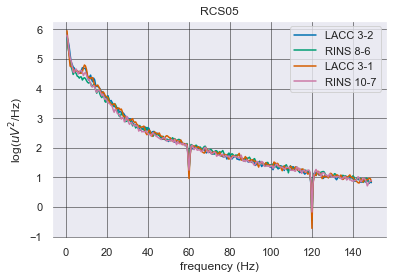

Running FOOOFGroup across 196 power spectra.
See:   /Users/Leriche/pia_server/datastore_spirit/human/nk_device_data/ephy_analysis/spectra//RCS05/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
Running FOOOFGroup across 196 power spectra.
RCS06
['LCM 6-5', 'RACCa 7-6', 'LCM 7-6']
(304, 3, 298)
(298,)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

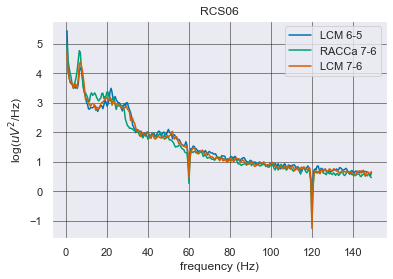

Running FOOOFGroup across 228 power spectra.
See:   /Users/Leriche/pia_server/datastore_spirit/human/nk_device_data/ephy_analysis/spectra//RCS06/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
Running FOOOFGroup across 228 power spectra.
RCS07
['LSGC 3-2', 'RSGC 2-1', 'RSGC 3-1']
(236, 3, 298)
(298,)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

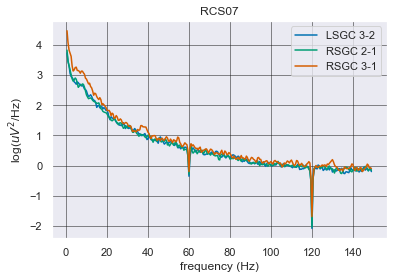

Running FOOOFGroup across 207 power spectra.
See:   /Users/Leriche/pia_server/datastore_spirit/human/nk_device_data/ephy_analysis/spectra//RCS07/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
Running FOOOFGroup across 207 power spectra.


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [7]:
sns.set_theme()
sense_homologs         = pd.read_excel(dirs['rcs_raw'] + 'sense_homologs_ONE_per_hemisphere.xlsx')
nk_periodic_spectra_ls = []

for i in range(len(pts)):
    
    raw_pwrspectra, fft_bins_inHz, ch_names, arm1_df = import_NK_spectra(pts[i], dirs)

    setup_fooof_dirs(pts[i], dirs, fooof_param)

    t_peri_ephy     = arm1_df.scales_vasmpq_timestamp
    i_keep          = [pd.isnull(t) == 0 for t in t_peri_ephy] 
    t_peri_ephy     = pd.to_datetime(t_peri_ephy.iloc[i_keep]).reset_index()
    t_peri_ephy     = t_peri_ephy.scales_vasmpq_timestamp

    bool_chan       = [any(a_ch == sense_homologs.loc[sense_homologs['pt'] == pts[i], 'NK_label']) for a_ch in ch_names]
    ind_sense_chan  = [i for i, x in enumerate(bool_chan) if x]

    #ind_sense_chan  = range(len(ch_names)-1)
    
    for i_ch in ind_sense_chan:
        spectra_oi = raw_pwrspectra[i_keep, i_ch, :]

        # FOOOF all spectra individually in single run
        fg = FOOOFGroup(
                        peak_width_limits  = fooof_param.peak_width_limits, 
                        max_n_peaks        = fooof_param.max_n_peaks, 
                        min_peak_height    = fooof_param.min_peak_height,
                        peak_threshold     = fooof_param.peak_threshold,
                        aperiodic_mode     = fooof_param.aperiodic_mode)

        # Model the power spectrum with FOOOF
        fg.fit(fft_bins_inHz, spectra_oi, fooof_param.freq_range)

        ### save aperiodic parameters, plot corr(aperiodic, time)
        [aperiodic_comp, raw_spectra, 
        fooof_spectra_aperiodic_rmv, freq_oi]   =  plt_save_fooof_analysis(pts[i], dirs, ch_names[i_ch], fooof_param, t_peri_ephy, fg)

        
        periodic_spectra = pd.DataFrame(
                            data   = fooof_spectra_aperiodic_rmv,
                            columns =  np.round(freq_oi, 1),
                            )

        periodic_spectra['pt_hemi'] = [pts[i]+ch_names[i_ch][0]]*fooof_spectra_aperiodic_rmv.shape[0]
        periodic_spectra['pt_chan'] = [ch_names[i_ch]]*fooof_spectra_aperiodic_rmv.shape[0]

        nk_periodic_spectra_ls.append(periodic_spectra)
        
        
        
        plt_save_avg_peaks(fooof_spectra_aperiodic_rmv, aperiodic_comp,
                               freq_oi,
                               pts[i], ch_names[i_ch], t_peri_ephy, fooof_param, dirs)
            
        ### only needed once per loop   
        if i_ch == ind_sense_chan[0]:
            pd.DataFrame(fg.freqs).to_excel(dirs['fooof_data'] + 'fooof_freqs.xlsx', index=False)
            print('See:   ' + dirs['error'] + '\nfor spectra with model error >' +  str(fooof_param.err_thresh))

* report specifics of FOOOF implementaion for publicaiton Methods section

In [8]:
methods_report_info(fg)

                                                                                                  
                                        FOOOF - REPORTING                                         
                                                                                                  
                    To report on using FOOOF, you should report (at minimum):                     
                                                                                                  
                              - the code version that was used used                               
                             - the algorithm settings that were used                              
                                - the frequency range that was fit                                
                                                                                                  
                                                                                                  
          

## FOOOF ambulatory (RCS, stage 1) data
* set pts and directories of where spectra exported are and where outputs should be saved

In [5]:
### main hemisphere and channels for-loops
pt_sides = ['RCS02R', 'RCS04R', 'RCS04L', 'RCS05R', 'RCS05L', 'RCS06R','RCS06L','RCS07L', 'RCS07R']

#time_lbls = ['5m_pre_survey','30s_pre_survey']
time_lbls = ['30s_pre_survey']

* set pts and directories of where spectra exported are and where outputs should be saved
    * note directories are set PER time of interest

ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS02R/stage1_only (pp work up)/30s_pre_survey/RCS02R_
(51, 4, 251)
['RACC +2-0', 'RACC +3-1', 'RVPL +10-8', 'RVPL +11-9']
(251,)
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS02R/stage1_only (pp work up)/30s_pre_survey/RCS02R_par_db.xlsx


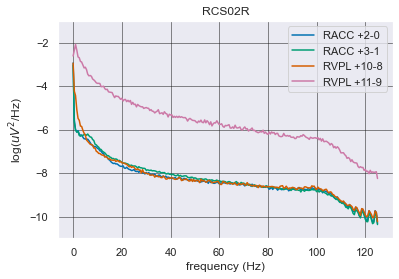

Running FOOOFGroup across 51 power spectra.


ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess//RCS02R//stage1_only (pp work up)/30s_pre_survey/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS04R/stage1_only (pp work up)/30s_pre_survey/RCS04R_
(86, 4, 251)
['RACC +3-0', 'RACC +3-1', 'RTHAL +11-8', 'RTHAL +10-8']
(251,)
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS04R/stage1_only (pp work up)/30s_pre_survey/RCS04R_par_db.xlsx


<Figure size 432x288 with 0 Axes>

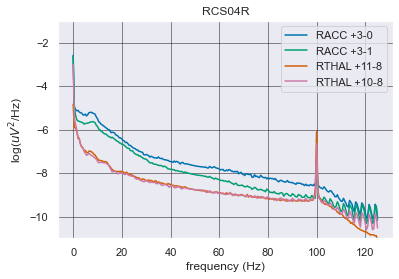

Running FOOOFGroup across 86 power spectra.


ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess//RCS04R//stage1_only (pp work up)/30s_pre_survey/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS04L/stage1_only (pp work up)/30s_pre_survey/RCS04L_
(80, 4, 251)
['LACC +3-0', 'LACC +3-1', 'LCaud +11-8', 'LCaud +11-9']
(251,)
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS04L/stage1_only (pp work up)/30s_pre_survey/RCS04L_par_db.xlsx


<Figure size 432x288 with 0 Axes>

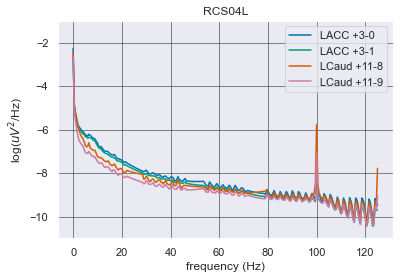

Running FOOOFGroup across 80 power spectra.


ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess//RCS04L//stage1_only (pp work up)/30s_pre_survey/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS05R/stage1_only (pp work up)/30s_pre_survey/RCS05R_
(64, 4, 251)
['RThal +2-0', 'RThal +3-1', 'RIFG +10-8', 'RIFG +11-9']
(251,)
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS05R/stage1_only (pp work up)/30s_pre_survey/RCS05R_par_db.xlsx


<Figure size 432x288 with 0 Axes>

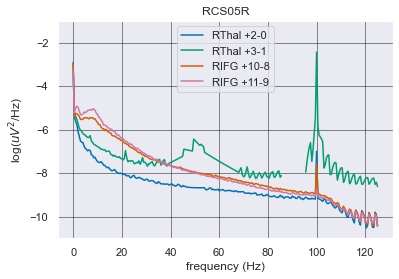

Running FOOOFGroup across 64 power spectra.


ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess//RCS05R//stage1_only (pp work up)/30s_pre_survey/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS05L/stage1_only (pp work up)/30s_pre_survey/RCS05L_
(60, 4, 251)
['LCaud +2-0', 'LCaud +2-1', 'LACC +11-8', 'LACC +11-9']
(251,)
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS05L/stage1_only (pp work up)/30s_pre_survey/RCS05L_par_db.xlsx


<Figure size 432x288 with 0 Axes>

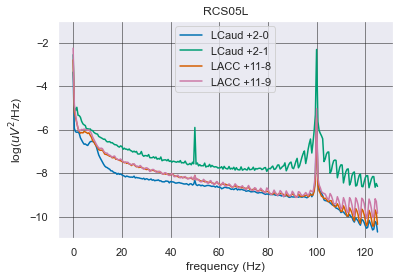

Running FOOOFGroup across 60 power spectra.


ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess//RCS05L//stage1_only (pp work up)/30s_pre_survey/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS06R/stage1_only (pp work up)/30s_pre_survey/RCS06R_
(63, 4, 251)
['RThal +2-0', 'RThal +3-1', 'RSFG +10-8', 'RSFG +11-9']
(251,)
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS06R/stage1_only (pp work up)/30s_pre_survey/RCS06R_par_db.xlsx


<Figure size 432x288 with 0 Axes>

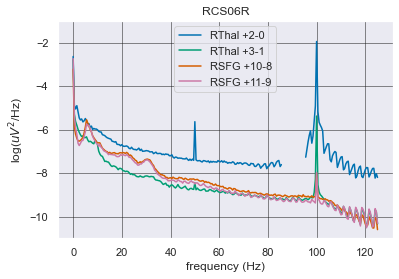

Running FOOOFGroup across 63 power spectra.


ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess//RCS06R//stage1_only (pp work up)/30s_pre_survey/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS06L/stage1_only (pp work up)/30s_pre_survey/RCS06L_
(155, 4, 251)
['LACC +2-0', 'LACC +3-1', 'LCaud +10-8', 'LCaud +11-9']
(251,)
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS06L/stage1_only (pp work up)/30s_pre_survey/RCS06L_par_db.xlsx


<Figure size 432x288 with 0 Axes>

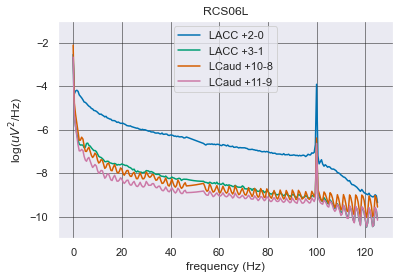

Running FOOOFGroup across 155 power spectra.


ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess//RCS06L//stage1_only (pp work up)/30s_pre_survey/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS07L/stage1_only (pp work up)/30s_pre_survey/RCS07L_
(183, 4, 251)
['LGPi +2-0', 'LGPi +3-1', 'LSGC +10-8', 'LSGC +11-9']
(251,)
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS07L/stage1_only (pp work up)/30s_pre_survey/RCS07L_par_db.xlsx


<Figure size 432x288 with 0 Axes>

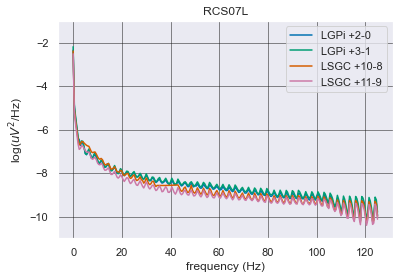

Running FOOOFGroup across 183 power spectra.


ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)
ERROR:root:ERROR: MATLAB type not supported: duration, (uint32)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess//RCS07L//stage1_only (pp work up)/30s_pre_survey/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS07R/stage1_only (pp work up)/30s_pre_survey/RCS07R_
(180, 4, 251)
['RThal +2-0', 'RThal +3-1', 'RSGC +10-8', 'RSGC +11-9']
(251,)
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS07R/stage1_only (pp work up)/30s_pre_survey/RCS07R_par_db.xlsx


<Figure size 432x288 with 0 Axes>

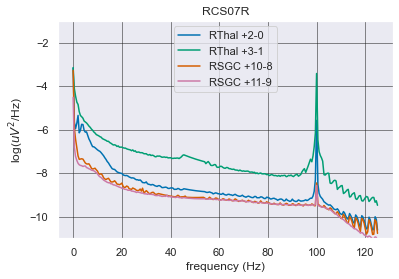

Running FOOOFGroup across 180 power spectra.
See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess//RCS07R//stage1_only (pp work up)/30s_pre_survey/fooofed (fixed)/error_ge_0.15/
for spectra with model error >0.15


<Figure size 432x288 with 0 Axes>

In [6]:
rcs_periodic_spectra_ls = []

for a_time in time_lbls:
    
    dirs = {'raw':       '/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/',
            'proc':      '/Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess/',
            'raw_sub':   '/stage1_only (pp work up)/'+ a_time+'/',
            'proc_sub':  '/stage1_only (pp work up)/'+ a_time+'/fooofed'}
    
    sense_homologs   = pd.read_excel(dirs['raw'] + 'sense_homologs_ONE_per_hemisphere.xlsx')


    for i in range(len(pt_sides)):

        pwrspectra_by_sess, fft_bins_inHz, ch_names, parsed_db_oi = import_FT_RCS_spectra(pt_sides[i], dirs)


        setup_fooof_dirs(pt_sides[i], dirs, fooof_param)

        bool_chan       = [any(a_ch == sense_homologs.loc[sense_homologs['pt'] == pt_sides[i][0:-1], 'RCS_label']) for a_ch in ch_names]
        ind_sense_chan  = [i for i, x in enumerate(bool_chan) if x]

        
      #  ind_sense_chan  = range(3) 
        
        t_peri_ephy = parsed_db_oi.timeStart

        for i_ch in ind_sense_chan:
            spectra_oi = pwrspectra_by_sess[:,i_ch, :]

            # FOOOF all spectra individually in single run
            fg = FOOOFGroup(
                            peak_width_limits  = fooof_param.peak_width_limits, 
                            max_n_peaks        = fooof_param.max_n_peaks, 
                            min_peak_height    = fooof_param.min_peak_height,
                            peak_threshold     = fooof_param.peak_threshold,
                            aperiodic_mode     = fooof_param.aperiodic_mode)

            # Model the power spectrum with FOOOF
            fg.fit(fft_bins_inHz, spectra_oi, fooof_param.freq_range)

            ### save aperiodic parameters, plot corr(aperiodic, time)
            [aperiodic_comp, raw_spectra, 
            fooof_spectra_aperiodic_rmv, freq_oi]   =  plt_save_fooof_analysis(pt_sides[i], dirs, ch_names[i_ch], fooof_param, t_peri_ephy, fg)

            #fm = plt_save_avg_peaks(fooof_spectra_aperiodic_rmv, aperiodic_comp, freq_oi, pt_sides[i], ch_names[i_ch], t_peri_ephy, fooof_param, dirs)

            periodic_spectra = pd.DataFrame(
                                data   = fooof_spectra_aperiodic_rmv,
                                columns =  np.round(freq_oi, 1),
                                )
            
            periodic_spectra['pt_hemi'] = [pt_sides[i]]*fooof_spectra_aperiodic_rmv.shape[0]
            periodic_spectra['pt_chan'] = [ch_names[i_ch]]*fooof_spectra_aperiodic_rmv.shape[0]
            
            rcs_periodic_spectra_ls.append(periodic_spectra)
            
            
            plt_save_avg_peaks(fooof_spectra_aperiodic_rmv, aperiodic_comp,
                               freq_oi,
                               pt_sides[i], ch_names[i_ch], t_peri_ephy, fooof_param, dirs)
            
            
            ### only needed once per loop   
            if i_ch == ind_sense_chan[0]:
                pd.DataFrame(fg.freqs).to_excel(dirs['fooof_data'] + 'fooof_freqs.xlsx', index=False)
                print('See:   ' + dirs['error'] + '\nfor spectra with model error >' +  str(fooof_param.err_thresh))

### FOOOFing spectra DONE

__________________________________________________________________________
__________________________________________________________________________
__________________________________________________________________________
### Supervised ML of ambulatory hemisphere spectra from inpatient spectra
Inputs

center frequencies from inpatient and ambulatory spectra (neuro-electrophysiology from the NK and RC+S, respectively)

* both from '1_nk_fooof_spectra' and '1_rcs_fooof_spectra'


Goals

Use Random Forest and/or Logistic Regression to identify pt hemisphere from spectra alone **within inpatient** stage

--> use ML on ambulatory stage (while never using ambulatory stage data in training)


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier


from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz, plot_tree
from IPython.display import Image

from sklearn import metrics

In [8]:
ALL_nk_periodic_spectra = pd.concat(nk_periodic_spectra_ls, 
                                 ignore_index=True,
                                  axis =0)


print('shape of "ALL_nk_periodic_spectra" is: ' + str(ALL_nk_periodic_spectra.shape))

n_col      = len(ALL_nk_periodic_spectra.columns)
i_freq_var = np.zeros(n_col, dtype=bool)

for i_col in range(n_col):
    if type(ALL_nk_periodic_spectra.columns[i_col]) == float:
        i_freq_var[i_col] = True
        
for i_spec in range(ALL_nk_periodic_spectra.shape[0]):
    
    spec      = ALL_nk_periodic_spectra.iloc[i_spec, i_freq_var]
    spec_mean = np.mean(spec,0)
    
    ALL_nk_periodic_spectra.iloc[i_spec, i_freq_var] = np.array(spec - spec_mean)

shape of "ALL_nk_periodic_spectra" is: (1572, 79)


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
                                                    ALL_nk_periodic_spectra.iloc[:, i_freq_var].values,
                                                    ALL_nk_periodic_spectra['pt_hemi'], 
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

In [10]:
def plt_conf_mat(y_test, y_pred, pt_sides, title1, title2):
    
    cm    = metrics.confusion_matrix(y_test, y_pred, normalize = 'true', labels=pt_sides)
    score = accuracy_score(y_test, y_pred)
    plt.figure(figsize=(8, 8))
    
    heat_map = sns.heatmap(cm, 
                annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r',
                xticklabels = pt_sides, 
                yticklabels = pt_sides,
                vmin=0, vmax=1)
    
    heat_map.collections[0].colorbar.set_label('Test Accuracy')
    
    plt.ylabel('Tested hemisphere');
    plt.xlabel('Predicted hemisphere');
    
    all_sample_title = '{}\n{}\nOverall test Accuracy ({:.2f})'.format(title1,title2, score)
    
    plt.title(all_sample_title, size = 15);
    
    return

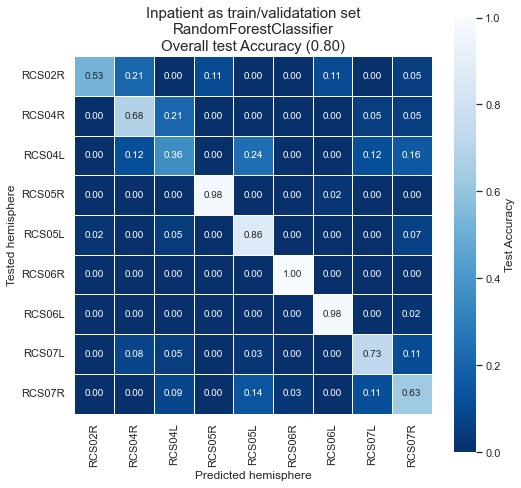

In [11]:
# histogram gradient boosting classifier
his_boost     = HistGradientBoostingClassifier(max_iter=100).fit(X_train, y_train)
y_pred_hist   = his_boost.predict(X_test)

# Logistic Regression
log_reg       = LogisticRegression(max_iter=5000, random_state=42).fit(X_train, y_train)
y_pred_lr     = log_reg.predict(X_test)

# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
y_pred_rf     = rf_classifier.predict(X_test)

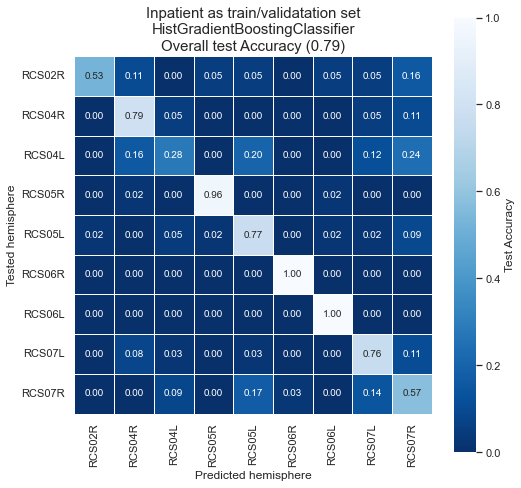

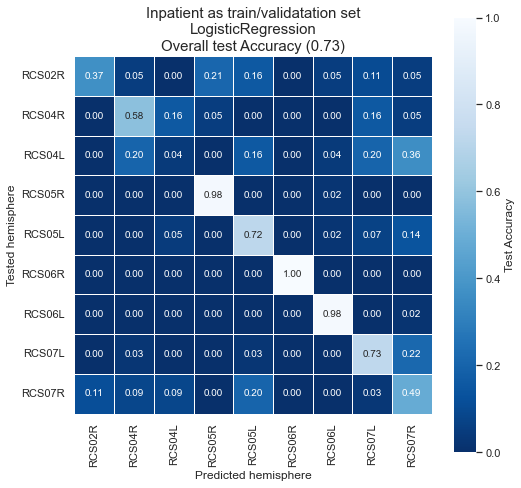

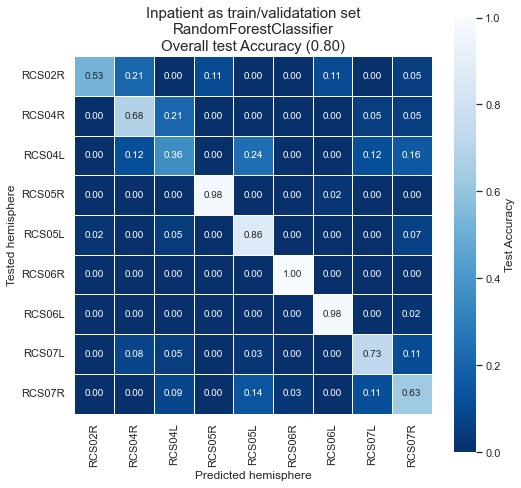

In [12]:
plt_conf_mat(y_test, y_pred_hist, pt_sides, 'Inpatient as train/validatation set', 'HistGradientBoostingClassifier')
plt_conf_mat(y_test, y_pred_lr, pt_sides, 'Inpatient as train/validatation set', 'LogisticRegression')
plt_conf_mat(y_test, y_pred_rf, pt_sides, 'Inpatient as train/validatation set', 'RandomForestClassifier')

* remove periodic spectra mean from RCS data

In [13]:
ALL_rcs_periodic_spectra = pd.concat(rcs_periodic_spectra_ls, 
                                 ignore_index=True,
                                  axis =0)

for i_spec in range(ALL_rcs_periodic_spectra.shape[0]):
    
    spec      = ALL_rcs_periodic_spectra.iloc[i_spec, i_freq_var]
    spec_mean = np.mean(spec,0)
    
    ALL_rcs_periodic_spectra.iloc[i_spec, i_freq_var] = np.array(spec - spec_mean)

ALL_RCS_spectra_arr = ALL_rcs_periodic_spectra.iloc[:, i_freq_var].values

* see NK trained model prediction of RCS spectra

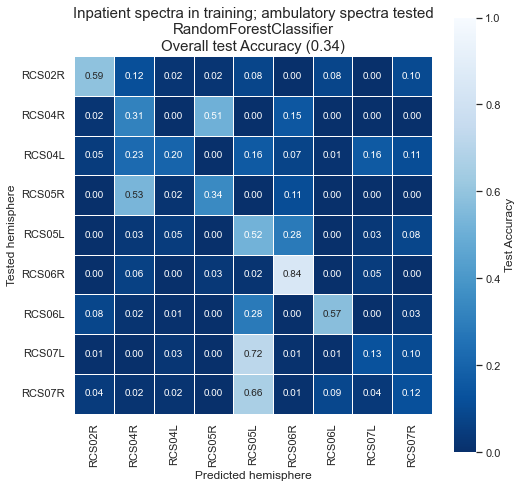

In [18]:
y_pred_rf_test   = rf_classifier.predict(ALL_RCS_spectra_arr)
y_test           = ALL_rcs_periodic_spectra.pt_hemi

plt_conf_mat(y_test,
             y_pred_rf_test, pt_sides, 
            'Inpatient spectra in training; ambulatory spectra tested', 'RandomForestClassifier')

## compare center frequencies, ampitudes and band widths

In [23]:
dirs = {'nk':       '/Volumes/DBS Pain 3/nk_device_data/processed/fooof_specs (30s_prior_to_survey, updated channels)/',
        'rcs':      '/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/',
        'rcs_sub':  '/stage1_only (pp work up)/30s_pre_survey/',
        'both_sub': '/exported_fooof_data/'
        }

In [24]:
nk_bands  = pd.read_excel(dirs['nk'] + 'ALL_bands.xlsx')
rcs_bands = pd.read_excel(dirs['rcs'] + 'ALL_bands.xlsx')
nk_bands.head()

,theta_freq,theta_pwr,theta_width,alpha_freq,alpha_pwr,alpha_width,b_low_freq,b_low_pwr,b_low_width,b_high_freq,b_high_pwr,b_high_width,pt_chan,pt_hemi
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RCS02R_RVPN 3-1,RCS02R
1,NaN,NaN,NaN,9.824881,0.490526,2.682602,19.727008,0.365808,6.0,NaN,NaN,NaN,RCS02R_RVPN 3-1,RCS02R
2,NaN,NaN,NaN,11.380146,0.397530,4.294283,NaN,NaN,NaN,NaN,NaN,NaN,RCS02R_RVPN 3-1,RCS02R
3,NaN,NaN,NaN,NaN,NaN,NaN,22.080446,0.234901,6.0,NaN,NaN,NaN,RCS02R_RVPN 3-1,RCS02R
4,NaN,NaN,NaN,10.664932,0.356150,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,RCS02R_RVPN 3-1,RCS02R


In [25]:
melt_list     = []
nk_bands_hemi = list(nk_bands.groupby(by='pt_hemi'))

for i in range(len(pt_sides)):
  
    hemi_bands                   = pd.melt(nk_bands_hemi[i][1][['theta_freq', 'alpha_freq', 'b_low_freq','b_high_freq']])
    hemi_bands.loc[:, 'pt_hemi'] = nk_bands_hemi[i][0]
    hemi_bands.loc[:, 'stage']   = 'inpatient'
    melt_list.append(hemi_bands)

rcs_bands_hemi = list(rcs_bands.groupby(by='pt_hemi'))

for i in range(len(pt_sides)):
  
    hemi_bands                   = pd.melt(rcs_bands_hemi[i][1][['theta_freq', 'alpha_freq', 'b_low_freq','b_high_freq']])
    hemi_bands.loc[:, 'pt_hemi'] = rcs_bands_hemi[i][0]
    hemi_bands.loc[:, 'stage']   = 'ambulatory'
    melt_list.append(hemi_bands)

    
bands_melt = pd.concat(melt_list, ignore_index=True).rename(columns={"variable": "power_band", "value": "peak_freq"})

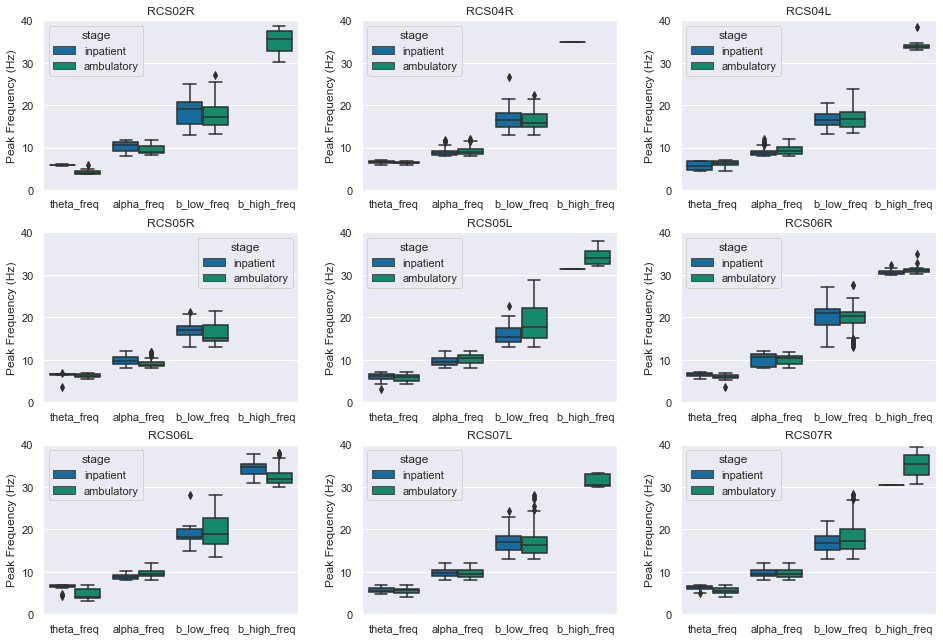

In [26]:
fig = plt.figure(figsize=(16, 10))

fig.patch.set_facecolor('white')

plt.subplots_adjust(top = .95, hspace = 0.25, wspace = 0.25)

for i in range(len(pt_sides)):
    
    ax = plt.subplot(3, 3, i+1)
    plt.title(pt_sides[i], fontsize = 12)
    
    hemi_bands = bands_melt.loc[bands_melt.pt_hemi == pt_sides[i], :]

    sns.boxplot(x    = "power_band",
                y    = "peak_freq",
                hue  = "stage",
                data = hemi_bands)
    
    ax.set_xlabel("") 
    ax.set_ylabel("Peak Frequency (Hz)")
    
    plt.ylim([0,40])

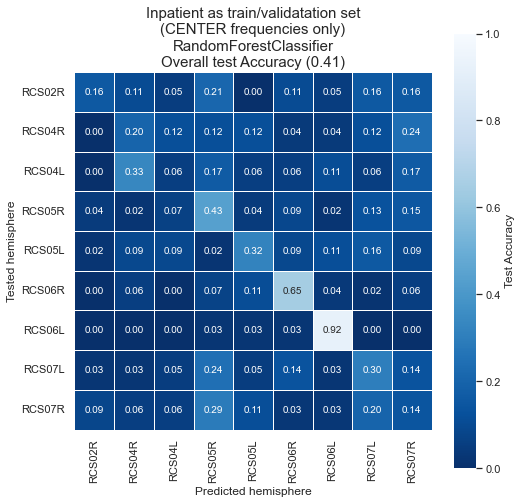

In [27]:
features = ['theta_freq', 'alpha_freq', 'b_low_freq','b_high_freq']
X        = nk_bands[features].values
i_nan    = np.isnan(X)
X[i_nan] = 0

nk_bands[features]= X

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
                                                    nk_bands[features],
                                                    nk_bands['pt_hemi'],  
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
y_pred_rf     = rf_classifier.predict(X_test)
plt_conf_mat(y_test, y_pred_rf, pt_sides, 'Inpatient as train/validatation set\n(CENTER frequencies only)', 'RandomForestClassifier')

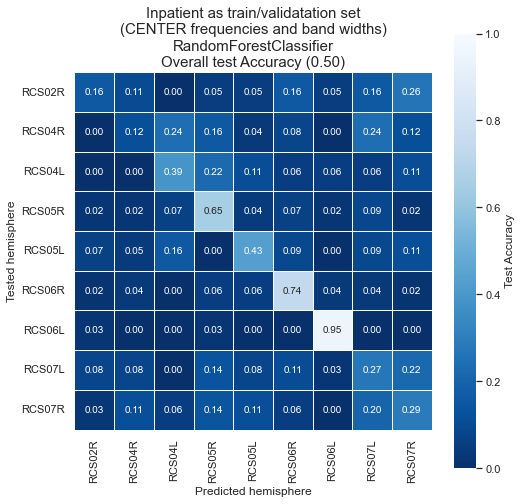

In [28]:
features = ['theta_freq', 'alpha_freq', 'b_low_freq','b_high_freq',
           'theta_width', 'alpha_width', 'b_low_width','b_high_width']

X        = nk_bands[features].values
i_nan    = np.isnan(X)
X[i_nan] = 0

nk_bands[features]= X

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
                                                    nk_bands[features],
                                                    nk_bands['pt_hemi'],  
                                                    test_size=0.2,
                                                    random_state=42
                                                    )
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
y_pred_rf     = rf_classifier.predict(X_test)
plt_conf_mat(y_test, y_pred_rf, pt_sides, 'Inpatient as train/validatation set\n(CENTER frequencies and band widths)', 'RandomForestClassifier')

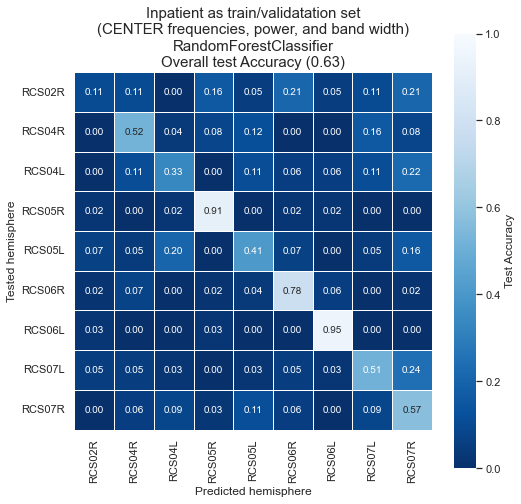

In [29]:
features = ['theta_freq', 'alpha_freq', 'b_low_freq','b_high_freq',
            'theta_width', 'alpha_width', 'b_low_width','b_high_width',
            'theta_pwr', 'alpha_pwr', 'b_low_pwr','b_high_pwr'
            ];

X        = nk_bands[features].values
i_nan    = np.isnan(X)
X[i_nan] = 0

nk_bands[features]= X

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
                                                    nk_bands[features],
                                                    nk_bands['pt_hemi'],  
                                                    test_size=0.2,
                                                    random_state=42
                                                    )
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
y_pred_rf     = rf_classifier.predict(X_test)
plt_conf_mat(y_test, y_pred_rf, pt_sides, 'Inpatient as train/validatation set\n(CENTER frequencies, power, and band width)', 'RandomForestClassifier')

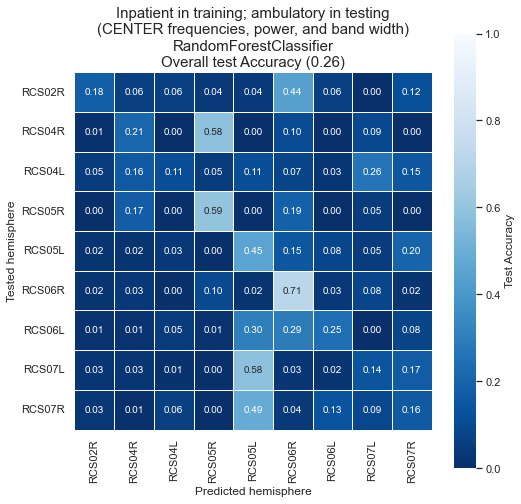

In [30]:
X        = rcs_bands[features].values
i_nan    = np.isnan(X)
X[i_nan] = 0

rcs_bands[features]= X


y_pred_rf     = rf_classifier.predict(rcs_bands[features])
y_test        = rcs_bands.pt_hemi
plt_conf_mat(y_test, y_pred_rf, pt_sides, 'Inpatient in training; ambulatory in testing\n(CENTER frequencies, power, and band width)', 'RandomForestClassifier')

# Within-hemisphere analyses
* ML approaches lack discrimination 
    * see hemisphere spectra themselves--not markedly different between hemispheres)
   
* re-orienting question back to reimplant similarity **within** brain region

Approach
* see proportion of spectra w/ peak in band (theta, alpha, low beta, high beta)

In [31]:
import pingouin as pg


### visualize spectra to intuit model confusion

In [32]:
# format NK and RCS spectra
nk_spectra  = ALL_nk_periodic_spectra
rcs_spectra = ALL_rcs_periodic_spectra


nk_spec_arr  = ALL_nk_periodic_spectra.iloc[:, i_freq_var].values
rcs_spec_arr = ALL_rcs_periodic_spectra.iloc[:, i_freq_var].values

min_pwr = np.round(
                (min(map(min, np.vstack((nk_spec_arr, rcs_spec_arr))))),
                1)
max_pwr = np.round(
                   (max(map(max, np.vstack((nk_spec_arr, rcs_spec_arr))))),
                    1)

max_pwr = np.round(max_pwr *.1 +max_pwr, 1)

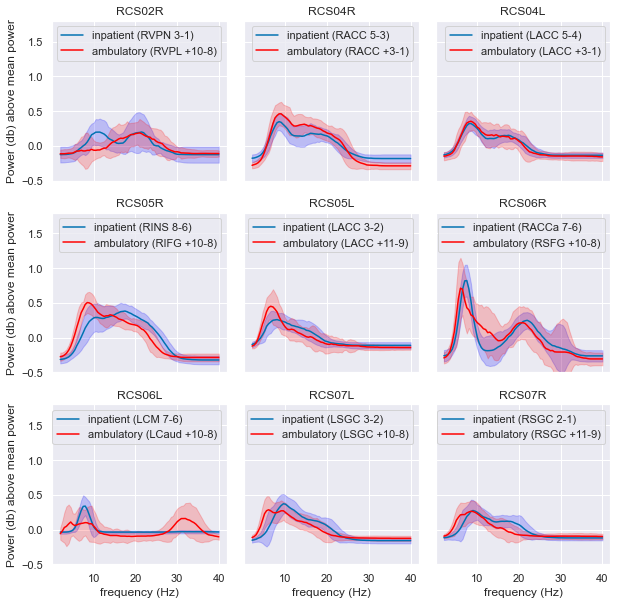

In [33]:
fig, axes = plt.subplots(3,3, figsize=[10,10], sharex=True, sharey=True,
                         gridspec_kw={'hspace': 0.2, 'wspace': 0.1})


# Flatten the axes array to easily iterate over it
axes = axes.flatten()

for i, ax in enumerate(axes):

    i_hemi      = nk_spectra.pt_hemi == pt_sides[i]
    plt_spec    = nk_spec_arr[i_hemi, :]

    median_nk   = np.median(plt_spec, axis=0)
    iqr         = np.percentile(plt_spec, 75, axis=0) - np.percentile(plt_spec, 25, axis=0) 

    ch_name     = 'inpatient ({})'.format(np.unique(nk_spectra[i_hemi].pt_chan)[0])

    # Plot the mean values as a solid line
    ax.plot(freq_oi, median_nk, label = ch_name)

    # Plot the shaded region for standard deviation
    ax.fill_between(freq_oi, median_nk - iqr, median_nk + iqr,
                    color='blue', alpha=0.2)
    
    ###
    i_hemi      = rcs_spectra.pt_hemi == pt_sides[i]
    plt_spec    = rcs_spec_arr[i_hemi, :]

    median_rcs  = np.median(plt_spec, axis=0)
    iqr         = np.percentile(plt_spec, 75, axis=0) - np.percentile(plt_spec, 25, axis=0) 

    ch_name     = 'ambulatory ({})'.format (np.unique(rcs_spectra[i_hemi].pt_chan)[0])

    # Plot the mean values as a solid line
    ax.plot(freq_oi, median_rcs, color='red', label = ch_name)
    # Plot the shaded region for standard deviation
    ax.fill_between(freq_oi, median_rcs - iqr, median_rcs + iqr,
                    color='red', alpha=0.2)

    ax.legend()
    plt.ylim([min_pwr, max_pwr])
    
    ax.set_title(pt_sides[i])
    
    
    if i % 3 == 0:
        ax.set_ylabel('Power (db) above mean power')

    if i >= 6:
        ax.set_xlabel('frequency (Hz)')

In [34]:
rcs_nk_df = pd.DataFrame({'median_rcs': median_rcs, 'median_nk': median_nk})

pg.kruskal(data=rcs_nk_df,dv='median_rcs', between='median_nk', detailed= True)

,Source,ddof1,H,p-unc
Kruskal,median_nk,76,76.0,0.478425


In [ ]:
nk_bands  = pd.read_excel(dirs['nk'] + 'ALL_bands.xlsx')
rcs_bands = pd.read_excel(dirs['rcs'] + 'ALL_bands.xlsx')

In [ ]:
features = ['theta_freq', 'alpha_freq', 'b_low_freq','b_high_freq']
bands    = ['theta_nk', 'alpha_nk', 'b_low_nk', 'b_high_nk']

In [ ]:
nk_bands.pt_hemi == pt_sides[i]

In [ ]:
hemi_nk_bands = nk_bands.pt_hemi

N_bands = nk_bands[features].isna().sum().values
nk_sum = pd.DataFrame({'Bands': bands, 'N_sess_w_band': N_bands, 'N_sess_total': len(nk_bands)}).set_index('Bands').T

bands    = ['theta_rcs', 'alpha_rcs', 'b_low_rcs', 'b_high_rcs']
N_bands = rcs_bands[features].isna().sum().values
rcs_sum = pd.DataFrame({'Bands': bands, 'N_sess_w_band': N_bands, 'N_sess_total': len(rcs_bands)}).set_index('Bands').T

spectra_sum = pd.concat([nk_sum, rcs_sum], axis=1)
spectra_sum 

In [ ]:
features = ['theta_freq', 'alpha_freq', 'b_low_freq','b_high_freq'];




for i in range(len(pt_sides):
     
                  
rcs_bands